In [9]:
import os
import time

import networkx as nx
import osmnx as ox
import geopandas as gpd
import pandas as pd
import numpy as np
import pandana as pdna
import requests
import matplotlib.cm as cm
import matplotlib.colors as colors
from IPython.display import Image

from functools import reduce 
ox.config(use_cache=True, log_console=True)
ox.__version__

'0.10'

In [4]:
def display_all(df):
    """
    convenience function to view a wide pandas dataframe
    """
    with pd.option_context("display.max_rows", 1000, "display.max_columns", 1000): 
        display(df)

In [3]:
place = "Berlin, Germany"
%time berlin_drive_net = ox.graph_from_place(place, network_type="drive", which_result=2)

CPU times: user 1min 43s, sys: 1.36 s, total: 1min 44s
Wall time: 1min 45s


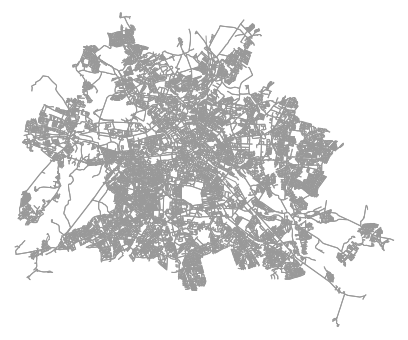

In [6]:
fig, ax = ox.plot_graph(berlin_road_net, node_size=0)

In [13]:
berlin_drive_nodes_df = pd.DataFrame([x[1] for x in list(berlin_drive_net.nodes(data=True))])[["x", "y", "osmid"]]
berlin_drive_nodes_df.set_index("osmid", inplace=True)

berlin_drive_net_edges = list(berlin_drive_net.edges.data('length'))
berlin_drive_net_edges = [{"from": x[0], "to": x[1], "weight": x[2]} for x in berlin_drive_net_edges]

berlin_drive_edges_df = pd.DataFrame(berlin_drive_net_edges)
berlin_drive_nodes_df.shape, berlin_drive_edges_df.shape

((27812, 2), (72617, 3))

In [14]:
pdnet=pdna.Network(berlin_drive_nodes_df["x"], berlin_drive_nodes_df["y"], 
                   berlin_drive_edges_df["from"], berlin_drive_edges_df["to"],
                   berlin_drive_edges_df[["weight"]])

/opt/conda/lib/python3.6/site-packages/pandana/network.py:82: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  nodes_df.astype('double').as_matrix(),
/opt/conda/lib/python3.6/site-packages/pandana/network.py:83: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  edges.as_matrix(),
/opt/conda/lib/python3.6/site-packages/pandana/network.py:85: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  .astype('double')
/opt/conda/lib/python3.6/site-packages/pandana/network.py:91: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  self.kdtree = KDTree(nodes_df.as_matrix())


#### Getting POIs from HERE

In [ ]:
%env here_maps_id=

In [4]:
%time berlin_gdf_place = ox.gdf_from_place(place, which_result=2)
%time polygons_for_api = berlin_gdf_place['geometry'].unary_union
%time response_jsons = ox.osm_net_download(polygon=polygons_for_api, network_type="walk")


CPU times: user 20 ms, sys: 0 ns, total: 20 ms
Wall time: 69.4 ms
CPU times: user 20 ms, sys: 0 ns, total: 20 ms
Wall time: 16 ms
CPU times: user 2.34 s, sys: 150 ms, total: 2.49 s
Wall time: 2.79 s


In [5]:
print(len(response_jsons))
print(response_jsons[0].keys())

1
dict_keys(['version', 'generator', 'osm3s', 'elements'])


In [6]:
berlin_walk_net_nodes, berlin_walk_net_paths = ox.core.parse_osm_nodes_paths(response_jsons[0])

In [7]:
len(berlin_walk_net_nodes), len(berlin_walk_net_paths)

(538353, 156579)

In [8]:
berlin_walk_net_nodes[172539]

{'y': 52.5652055, 'x': 13.3355015, 'osmid': 172539}

In [28]:
list(berlin_walk_net_paths.keys())[0]

4045150

In [29]:
berlin_walk_net_paths[4045150]

{'osmid': 4045150,
 'nodes': [1234120411,
  6375730236,
  262876417,
  262877047,
  21432146,
  6376074936,
  6376074921,
  6376074922,
  6376074932,
  262146912,
  262877156,
  262146871,
  32495413],
 'name': 'Waldstraße',
 'maxspeed': '50',
 'highway': 'residential'}

In [9]:
berlin_walk_net = nx.MultiDiGraph(crs=ox.settings.default_crs)

# extract nodes and paths from the downloaded osm data
nodes = {}
paths = {}

for key, value in berlin_walk_net_nodes.items():
    nodes[key] = value

print(len(nodes.keys()))
for key, value in berlin_walk_net_paths.items():
    paths[key] = value
print(len(paths.keys()))
# add each osm node to the graph
for node, data in nodes.items():
    berlin_walk_net.add_node(node, **data)
print("done adding nodes")
# add each osm way (aka, path) to the graph
%time berlin_walk_net = ox.add_paths(berlin_walk_net, paths, bidirectional=True)

# in this case, this seems to crash the python process/ takes a very long time
# %time berlin_walk_net= ox.utils.get_largest_component(berlin_walk_net)


538353
156579
done adding nodes
CPU times: user 16.8 s, sys: 590 ms, total: 17.4 s
Wall time: 18.6 s


In [11]:
%time berlin_walk_net = ox.core.add_edge_lengths(berlin_walk_net)

CPU times: user 28.9 s, sys: 13.4 s, total: 42.3 s
Wall time: 2min 17s


In [13]:
%time berlin_walk_net_nodes_df = pd.DataFrame([x[1] for x in list(berlin_walk_net.nodes(data=True))])[["x", "y", "osmid"]]

%time berlin_walk_net_edges = list(berlin_walk_net.edges.data('length'))
%time berlin_walk_net_edges = [{"from": x[0], "to": x[1], "weight": x[2]} for x in berlin_walk_net_edges]

%time berlin_walk_net_edges_df = pd.DataFrame(berlin_walk_net_edges)
%time berlin_walk_net_nodes_df.shape, berlin_walk_net_edges_df.shape

CPU times: user 3.06 s, sys: 40 ms, total: 3.1 s
Wall time: 3.21 s
CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 57 µs


((538353, 2), (1246622, 3))

In [16]:
berlin_walk_net_edges_df.to_feather("berlin_walk_net_edges.feather")
berlin_walk_net_nodes_df.to_feather("berlin_walk_net_nodes.feather")

In [19]:

berlin_walk_net_nodes_df.head()

,osmid,x,y
0,172539,13.335501,52.565205
1,172540,13.336406,52.564725
2,172541,13.336410,52.565639
3,172542,13.337555,52.566000
4,172543,13.339437,52.566312


In [18]:
berlin_walk_net_edges_df.head()

,from,to,weight
0,172539,3244748546,10.233
1,172539,5740302736,13.416
2,172539,5740302737,14.497
3,172540,5136626301,34.120
4,172540,2383000642,5.021


In [23]:
# nx.is_weakly_connected(berlin_walk_net)

    # get all the weakly connected components in graph then identify the largest
wccs = nx.weakly_connected_components(berlin_walk_net)
#     largest_wcc = max(wccs, key=len)
#     G = induce_subgraph(G, largest_wcc)

# berlin_walk_net.is_directed()

In [24]:
largest_wcc = max(wccs, key=len)

In [ ]:
berlin_walk_net = ox.utils.induce_subgraph(berlin_walk_net, largest_wcc)

In [5]:
berlin_road_net